In [11]:
import sys

# To recognize the utils folder 
sys.path.append("..")

In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import torch

assert torch.backends.mps.is_available()
assert torch.backends.mps.is_built()

In [3]:
df = pd.read_csv('../datasets/HomoSapiens_binary_hq.txt', sep='\t')
df.head()

,Uniprot_A,Uniprot_B,Gene_A,Gene_B,ORF_A,ORF_B,Alias_A,Alias_B,pmid:method:quality
0,A0A024QYV7,A0A024QYV7,A0A024QYV7,A0A024QYV7,HCG_1994130,HCG_1994130,NaN,NaN,14667819:0018:HT
1,A0A024QYV7,Q01844,A0A024QYV7,EWSR1,HCG_1994130,NaN,NaN,HGNC:3508,16189514:0398:HT|16189514:0018:HT
2,A0A024QYV7,Q13838,A0A024QYV7,DDX39B,HCG_1994130,NaN,NaN,HGNC:13917,14667819:0018:HT
3,A0A024QYV7,Q16543,A0A024QYV7,CDC37,HCG_1994130,NaN,NaN,HGNC:1735,21900206:0018:HT
4,A0A024QYV7,Q9UKW6,A0A024QYV7,ELF5,HCG_1994130,NaN,NaN,HGNC:3320,16189514:0398:HT|16189514:0018:HT


In [4]:
edge_pairs = []
for _, row in df.iterrows():
    val = (row["Uniprot_A"], row["Uniprot_B"])
    edge_pairs.append(val)

edge_pairs[:3]

[('A0A024QYV7', 'A0A024QYV7'),
 ('A0A024QYV7', 'Q01844'),
 ('A0A024QYV7', 'Q13838')]

In [5]:
ppin = nx.Graph()
ppin.add_edges_from(edge_pairs)

In [6]:
nx.number_of_selfloops(ppin) / len(ppin)

0.31704301425131776

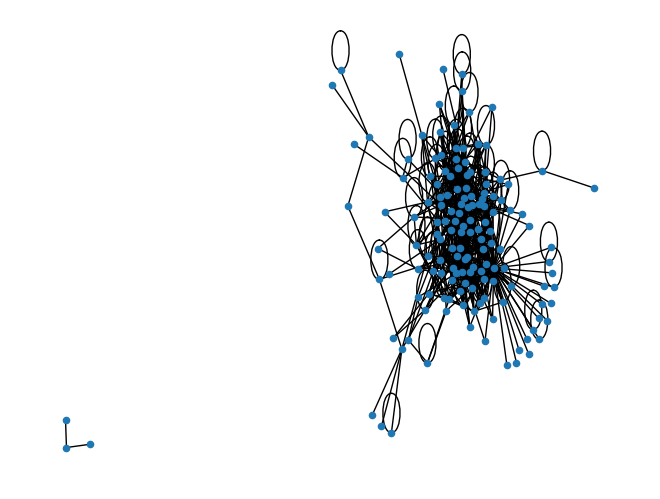

In [9]:
from utils.graph import draw_n_nodes

draw_n_nodes(ppin, n=150)

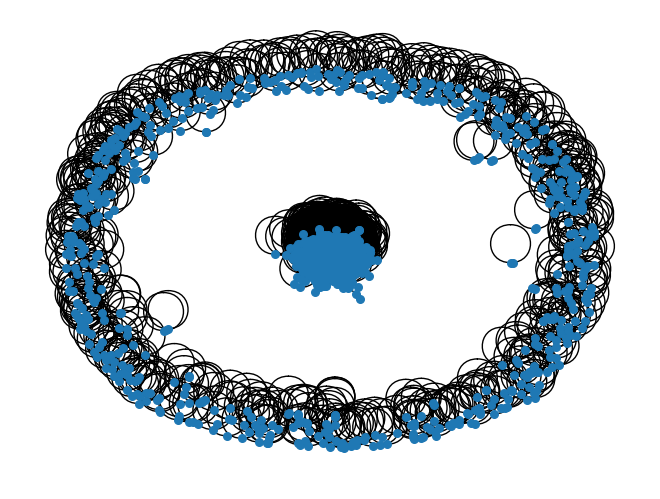

In [27]:
pos = nx.spring_layout(ppin)
nx.draw(ppin, pos, with_labels=False)

# Sanity Check with `torch_geometric` PPI Dataset

In [13]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [19]:
import torch_geometric.transforms as T

transform = T.Compose(
    [
        T.NormalizeFeatures(),
        T.ToDevice(device),
        T.RandomLinkSplit(
            num_val=0.05,
            num_test=0.1,
            is_undirected=True,
            split_labels=True,
            add_negative_train_samples=False,
        ),
    ]
)

In [21]:
from torch_geometric.datasets import PPI

dataset = PPI(root="../datasets/", transform=transform)
train_data, val_data, test_data = dataset[13]  # largest graph
train_data, val_data, test_data

(Data(x=[3480, 50], edge_index=[2, 90744], y=[3480, 121], pos_edge_label=[45372], pos_edge_label_index=[2, 45372]),
 Data(x=[3480, 50], edge_index=[2, 90744], y=[3480, 121], pos_edge_label=[2668], pos_edge_label_index=[2, 2668], neg_edge_label=[2668], neg_edge_label_index=[2, 2668]),
 Data(x=[3480, 50], edge_index=[2, 96080], y=[3480, 121], pos_edge_label=[5337], pos_edge_label_index=[2, 5337], neg_edge_label=[5337], neg_edge_label_index=[2, 5337]))

In [22]:
from torch_geometric.nn import GCNConv


class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, dim_out * 2)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [23]:
from torch_geometric.nn import VGAE

encoder = Encoder(dataset.num_features, 16).to(device)

model = VGAE(encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [24]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    
    loss.backward()
    optimizer.step()
    return float(loss)

In [25]:
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

In [35]:
for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(val_data)
    if epoch % 50 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.4f} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

Epoch   0 | Loss: 1.1415 | Val AUC: 0.7808 | Val AP: 0.7954
Epoch  50 | Loss: 1.1439 | Val AUC: 0.7794 | Val AP: 0.7947
Epoch 100 | Loss: 1.1398 | Val AUC: 0.7764 | Val AP: 0.7932
Epoch 150 | Loss: 1.1421 | Val AUC: 0.7827 | Val AP: 0.7968
Epoch 200 | Loss: 1.1369 | Val AUC: 0.7853 | Val AP: 0.7983
Epoch 250 | Loss: 1.1444 | Val AUC: 0.7813 | Val AP: 0.7962
Epoch 300 | Loss: 1.1425 | Val AUC: 0.7806 | Val AP: 0.7959


In [36]:
test_auc, test_ap = test(test_data)
print(f'Test AUC: {test_auc:.4f} | Test AP {test_ap:.4f}')

Test AUC: 0.7908 | Test AP 0.8164


In [37]:
z = model.encode(test_data.x, test_data.edge_index)
Ahat = torch.sigmoid(z @ z.T)

(Ahat > 0.5).float()

tensor([[1., 0., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.],
        ...,
        [1., 0., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 1., 0., 1.]], device='mps:0')

In [ ]:
# TODO: print original adjacency matrix